In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from msdm.domains.gridgame.tabulargridgame import TabularGridGame
from msdm.domains.gridworld.mdp import GridWorld
from msdm.algorithms.multiagentqlearning import TabularMultiAgentQLearner
from msdm.algorithms.friendfoeq import FriendFoeQ
from msdm.algorithms.correlatedq import CorrelatedQLearner
from msdm.algorithms.nashq import NashQLearner
from msdm.core.problemclasses.stochasticgame.policy.tabularpolicy import SingleAgentPolicy
from msdm.core.assignment.assignmentmap import AssignmentMap
import msdm
import numpy as np
import importlib
import itertools
from IPython.display import HTML,display

In [3]:
three_player_gamestring = """
# # # # # # # 
# A1 . A2 . A0 #
# . . . . . # 
# G1 . G2 . G0 #
# # # # # # #  
""".strip()

two_player = """
# # # # #
# . G . # 
# u . u #
# A0 . A1 #
# # # # #
"""
# gg = TabularGridGame(new_gamestring,agent_symbols=("A0","A1","A2"),goal_symbols=(
#                      ("G0", ("A0", )),
#                      ("G1", ("A1", )),
#                      ("G2",("A2", )),
#                      ("G", ("A0", "A1"))),)
gg = TabularGridGame(two_player,agent_symbols=("A0","A1"),goal_symbols=(("G",("A0","A1")),))
gg.state_list
print("State list generated")

State list generated


In [4]:
learning_agents = ["A0","A1"]
friends = {"A1":["A0"],"A0":["A1"]}
foes = {"A1":[],"A0":[]}
other_policies = {}
q_learner = TabularMultiAgentQLearner(learning_agents,other_policies,num_episodes=100,epsilon=.1,discount_rate=.99,all_actions=False,show_progress=True,alg_name="Q-Learning")
ffq_learner = FriendFoeQ(learning_agents,friends,foes,other_policies,num_episodes=100,epsilon=.1,discount_rate=.99,show_progress=True,alg_name="FFQ-Learning")
correlated_q_learner = CorrelatedQLearner(learning_agents,other_policies,num_episodes=100,epsilon=.1,discount_rate=.99,objective_func="Libertarian",show_progress=True,alg_name="Correlated Q-Learning")
nash_q_learner = NashQLearner(learning_agents,other_policies,num_episodes=100,epsilon=.1,discount_rate=.99,show_progress=True,alg_name="Nash-Q Learning")
algorithms = [q_learner,ffq_learner,correlated_q_learner,nash_q_learner]

In [5]:
results = []
example_trajectories = []
for alg in algorithms:
    res = alg.train_on(gg)
    results.append(res)
    trajectory = res.pi.run_on(gg,maxSteps=10)
    example_trajectories.append(trajectory)

Training with Nash-Q Learning: 100%|██████████| 100/100 [07:45<00:00,  4.65s/it]


Calculating Projected Q-Values: 100%|██████████| 73/73 [00:00<00:00, 4472.06it/s]


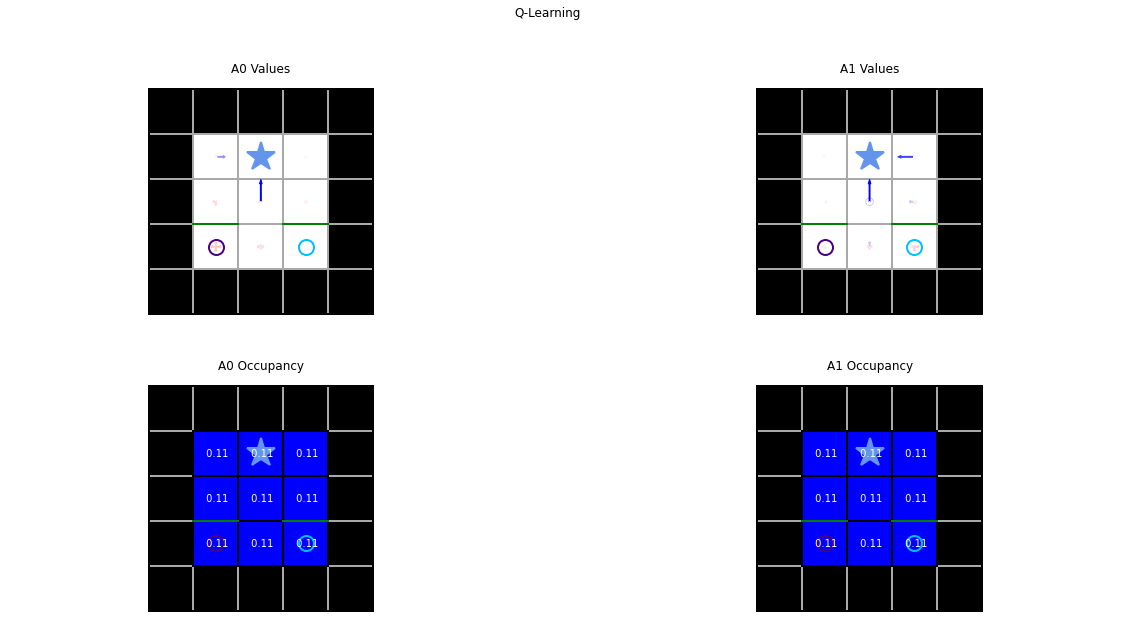

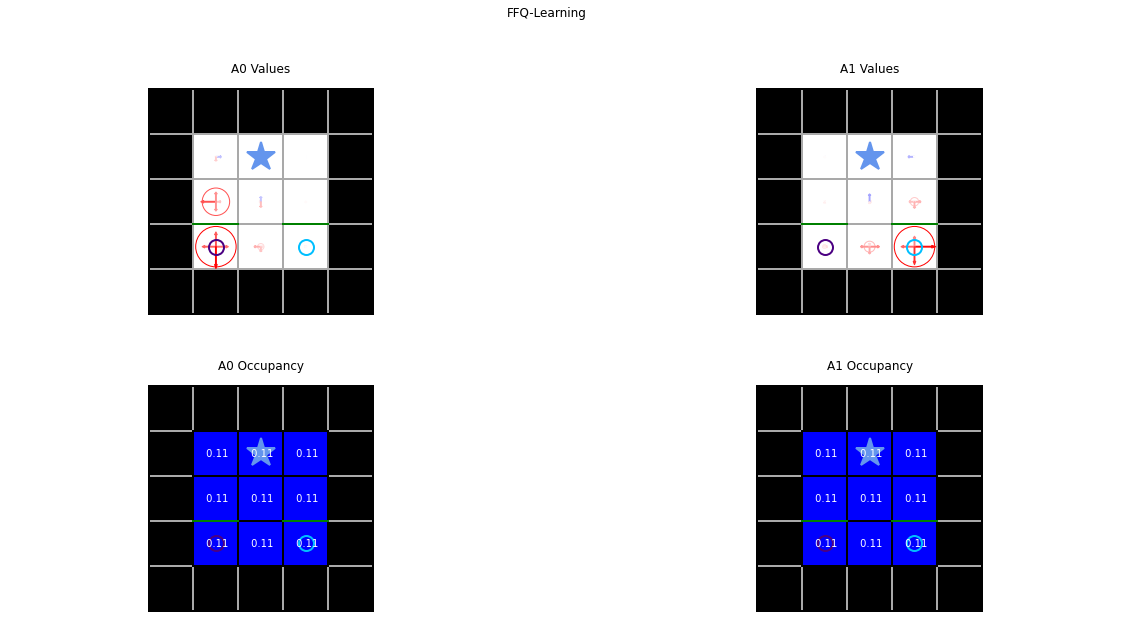

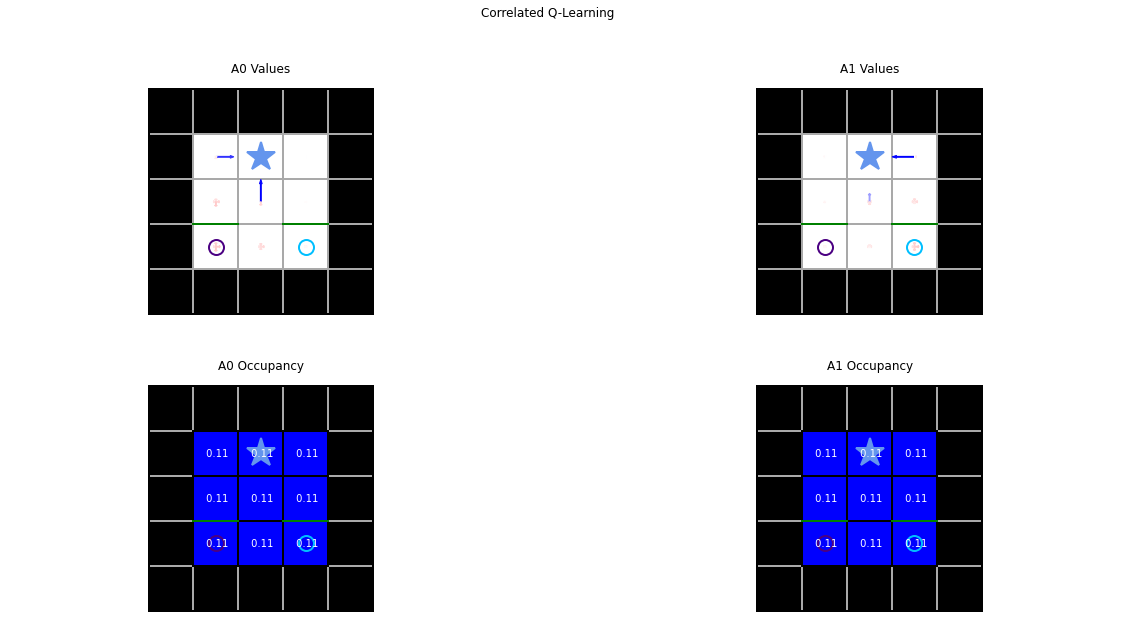

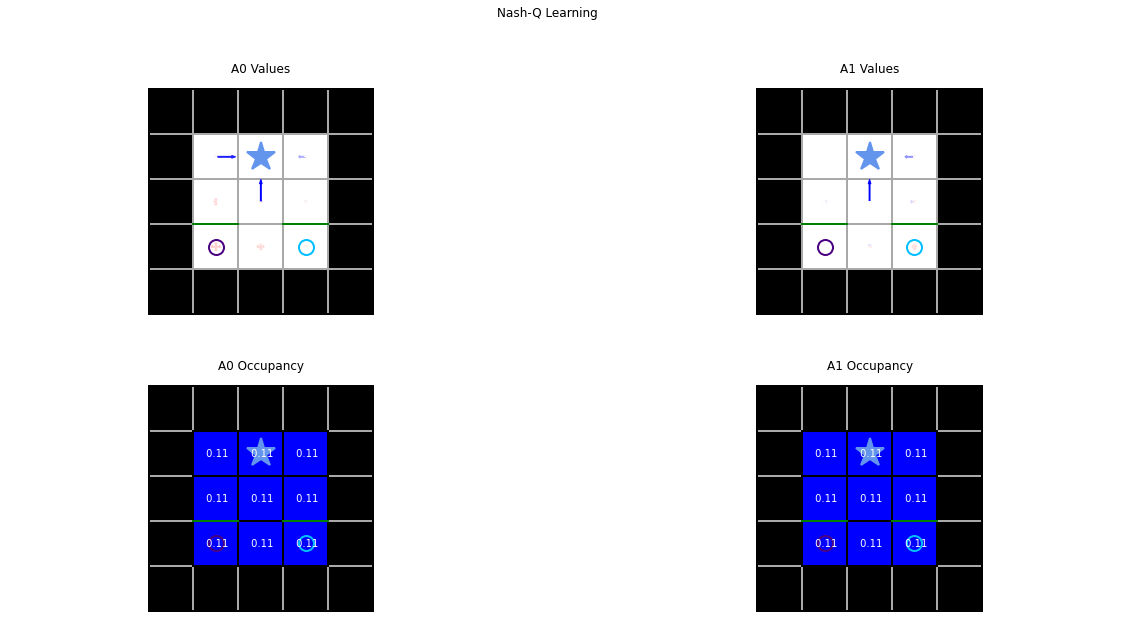

In [14]:
for k,alg in enumerate(algorithms): 
    fig,axes = plt.subplots(2,len(learning_agents),figsize=(20,10))
    fig.suptitle(alg.alg_name)
    for i,agent_name in enumerate(learning_agents):
        plotter = gg.plot(ax=axes[0][i])
        plotter.title(agent_name + " Values")
        q_matrix = results[k].pi.single_agent_policies[agent_name].q_matrix
        occupancy_matrix = results[k].pi.occupancy_matrix
        occupancy_matrix = np.zeros_like(occupancy_matrix)
        occupancy_matrix.fill(1.0/occupancy_matrix.shape[1])
        initial_state = gg.initial_state_dist().sample()
        initial_index = gg.state_list.index(initial_state)
        plotter.plot_state_action_map(results[k].pi.positionActionMapping(agent_name,q_matrix,occupancy_matrix,initial_state))
        plotter = gg.plot(ax=axes[1][i])
        plotter.title(agent_name + " Occupancy")
        plotter.plot_weights(results[k].pi.weightMapping(agent_name,occupancy_matrix,initial_state))

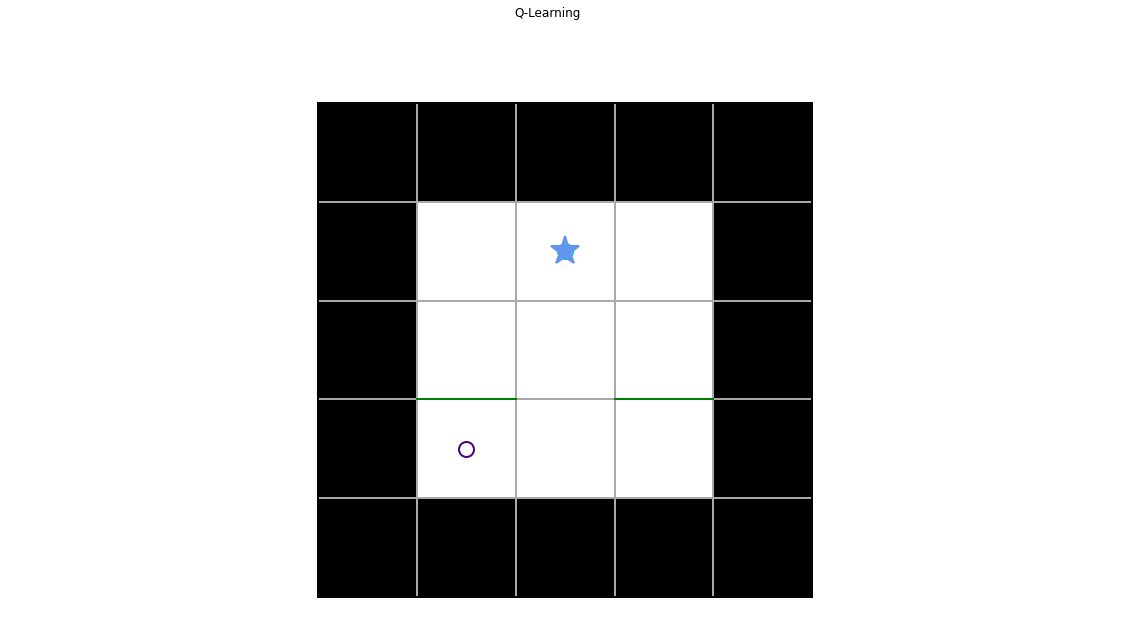

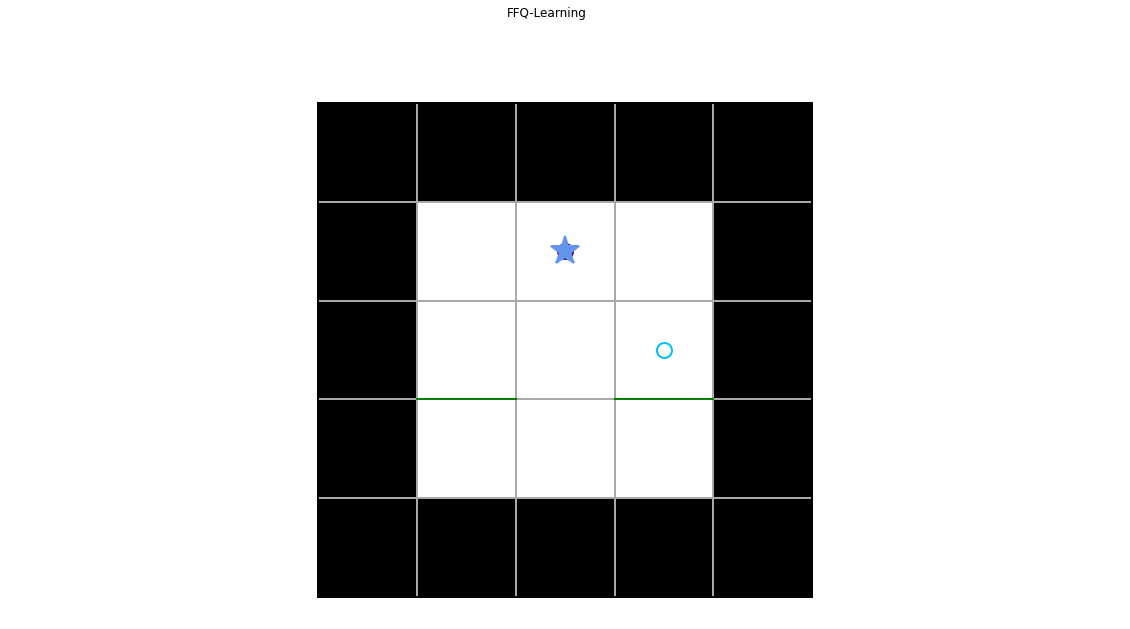

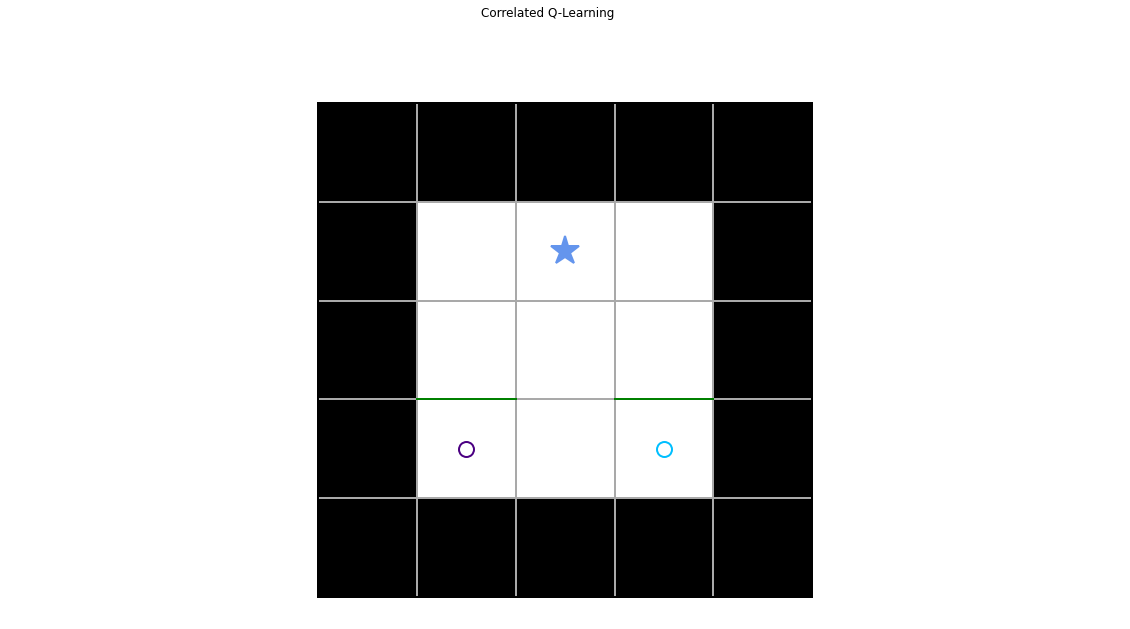

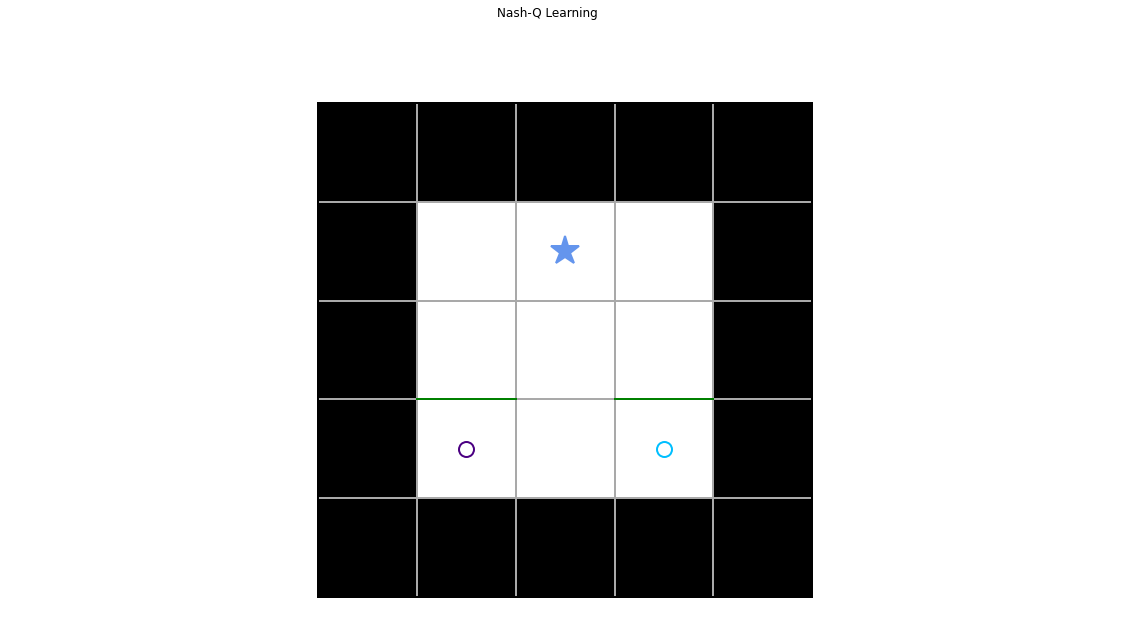

In [8]:
animations = []
for k,alg in enumerate(algorithms):
    fig, axes = plt.subplots(1,1,figsize=(20,10))
    fig.suptitle(alg.alg_name)
    animator = gg.animate(figure=fig,ax=axes)
    animation = animator.animate_trajectory(example_trajectories[k])
    animations.append(animation)
display(*[HTML(animation.to_jshtml()) for animation in animations])